In [1]:
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
import os
from Scripts.DataManager.GraphLoader.AGGraphDataModule import AGGraphDataModule
import torch

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
# config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding4 import HeteroDeepGraphEmbedding4
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding5 import HeteroDeepGraphEmbedding5

In [3]:
from Scripts.Models.LightningModels.LightningModels import HeteroMultiClassLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import MulticlassHeteroLoss1
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [4]:

graph_type = TextGraphType.SENTIMENT
data_manager = AGGraphDataModule(config, True, True, test_size=0.055, val_size=0.01, shuffle=False, start_data_load=0 , end_data_load = 127000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AG\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 127/127 [14:04<00:00,  6.65s/it]


In [5]:
test_dataloader = data_manager.test_dataloader()
X3, Y3 = next(iter(test_dataloader))

In [6]:
X3.metadata()

(['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [7]:

edge_type_weights = {
    # 'full': [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    'full-non-sentiment': [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
    # 'seq': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'dep': [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'tag': [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    # 'general_sentence': [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
    # 'sentence': [0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
    # 'sentiment': [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
}
# type_checkpoint = {
#     #  'dep': r'logs\hetero_model_14_AG\version_0\checkpoints\epoch=38-step=17199.ckpt',
#      'tag': r'logs\hetero_model_15_AG_tag\version_0\checkpoints\epoch=9-step=4410.ckpt',
#      'general_sentence': '',
#      'sentence': '',
# }

In [8]:
# edge_type_weights = {
#     'seq_gen': [1, 1, 1],
#     'seq': [0, 0, 1]
# }
# type_checkpoint = {
#     'seq_gen': r'logs\hetero_model_12_AG\version_1\checkpoints\epoch=24-step=11025.ckpt',
#     'seq': r'logs\hetero_model_12_AG\version_2\checkpoints\epoch=22-step=10143.ckpt'
# }

In [9]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model_mgr.lightning_model.eval()
        model_mgr.lightning_model.model.eval()
        model_mgr.torch_model.eval()
        for X, y in eval_dataloader:
            model_mgr.trainer.model.eval()
            with torch.no_grad():
                y_p = model_mgr.trainer.model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [11]:

for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding5(300, 4, X3.metadata(), 256, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[k])
    graph_embedding = graph_embedding.to(device)
    callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]
    loss_func = MulticlassHeteroLoss1(exception_keys=['word'], enc_factor=0.01)
    optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.01, weight_decay=0.001)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45, 60, 75, 90], gamma=0.6, verbose=True)
    lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        learning_rate=0.01,
                                        batch_size=batch_size,
                                        user_lr_scheduler=True,
                                        min_lr=0.0004
                                        ).to(device)
    lightning_model.model.to(device)
          
    model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_17_AG',device=device, num_train_epoch=200)
    model_manager.fit(datamodule=data_manager)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding5.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
---------------------------------------------

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
graph_embedding = HeteroDeepGraphEmbedding4(300, 4, X3.metadata(), 256, device, 0.2, 11)
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_11_AG\version_5\checkpoints\epoch=1-step=882.ckpt', 
                                    model=graph_embedding,
                                    num_classes=4)
                                    # ,
                                    # optimizer=optimizer,
                                    # loss_func=loss_func,
                                    # learning_rate=0.001,
                                    # batch_size=batch_size,
                                    # lr_scheduler=lr_scheduler,
                                    # user_lr_scheduler=True,
                                    # min_lr=0.00003)

In [ ]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, l_model, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        for X, y in eval_dataloader:
            l_model.eval()
            with torch.no_grad():
                y_p = l_model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)
        
        # test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=4)
        # test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=4)
        # test_precision = torchmetrics.Precision(task="multiclass", num_classes=4)
        # test_recall = torchmetrics.Recall(task="multiclass", num_classes=4)
        # test_confusion_m = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)
        
        # print(f'test_acc: {test_acc(y_true_num, y_pred_num)}')
        # print(f'test_f1: {test_f1(y_true_num, y_pred_num)}')
        # print(f'test_precision: {test_precision(y_true_num, y_pred_num)}')
        # print(f'test_recall: {test_recall(y_true_num, y_pred_num)}')
        # print(f'test_confusion_m: \n{test_confusion_m(y_true_num, y_pred_num)}')

In [ ]:
lightning_model.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
save_evaluation(model_manager, lightning_model, data_manager.test_dataloader(), 'chpt_n',True, True, True, True, True, True, True, multi_class=True)

torch.Size([6985, 4])
torch.Size([6985, 4])
torch.Size([6985])
torch.Size([6985])


In [ ]:
optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_16_AG\version_12\checkpoints\epoch=137-step=60858.ckpt', 
                                    model=graph_embedding,
                                    num_classes=4)
        
save_evaluation(model_manager, lightning_model, data_manager.test_dataloader(), 'chpt_1',True, True, True, True, True, True, True, multi_class=True)

Adjusting learning rate of group 0 to 1.0000e-03.


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [ ]:
model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_16_AG\version_12\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding5 | 4.0 M 
1 | loss_func | MulticlassHeteroLoss1     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
4.0 M     Trainable params
11        Non-trainable params
4.0 M     Total params
15.957    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

In [ ]:

model_manager.trainer.model.eval()
model_manager.trainer.model(X3)

(tensor([[ 0.0119, -5.3836, -0.8138,  5.6585],
         [-0.5171, -1.4353, -1.7620,  3.3852],
         [-0.5625, -3.4890,  0.5424,  3.2266],
         ...,
         [ 0.6585,  5.6110, -4.2732, -2.3721],
         [ 7.6873, -8.2410, -0.7907,  0.7995],
         [-1.3680, -2.5770,  2.6620,  0.9521]], grad_fn=<AddmmBackward0>),
 {'dep': tensor([[0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          ...,
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001]],
         grad_fn=<LeakyReluBackward0>),
  'tag': tensor([[0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          [0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          [0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          ..

In [ ]:
# t_dataloader = data_manager.train_dataloader()

for X1, y1 in test_dataloader:
    model_manager.trainer.model.eval()
    with torch.no_grad():
        y1_pred = model_manager.trainer.model(X1.to(device))
    acc = model_manager.lightning_model.train_acc(torch.argmax(y1_pred[0], dim=1), torch.argmax(y1.to(device), dim=1))
    print(acc)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# X1, y1 = next(iter(t_dataloader))
model_manager.lightning_model.train_acc

MulticlassAccuracy()

torch.Size([6985, 4])
torch.Size([6985, 4])
torch.Size([6985])
torch.Size([6985])
test_acc: 0.881030797958374
test_f1: 0.881030797958374
test_precision: 0.881030797958374
test_recall: 0.881030797958374
test_confusion_m: 
tensor([[1530,   35,   45,   74],
        [  37, 1632,    8,    9],
        [ 136,   42, 1454,  114],
        [  54,   39,  238, 1538]])


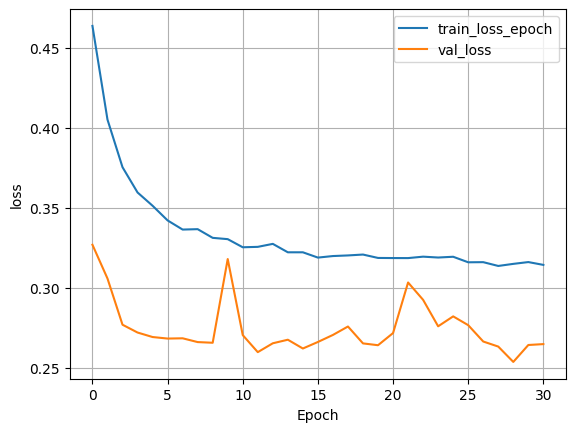

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

test_acc: 0.6729172468185425
test_f1: 0.6729172468185425
test_precision: 0.6729172468185425
test_recall: 0.6729172468185425
test_confusion_m: 
tensor([[1699,  441,  676,  424],
        [  17, 1312,   16,   26],
        [  18,    8, 1111,  625],
        [  10,    8,   16,  579]])


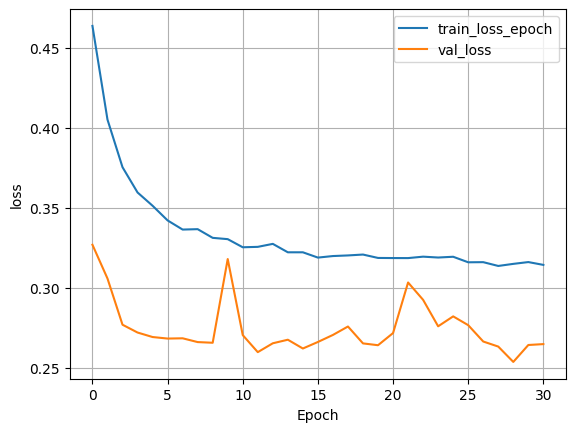

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

test_acc: 0.6320773363113403
test_f1: 0.6320773363113403
test_precision: 0.6320773363113403
test_recall: 0.6320773363113403
test_confusion_m: 
tensor([[27739,  8801, 11597,  9042],
        [  179, 19189,   332,   429],
        [  223,   121, 15893, 10335],
        [   79,    75,   324,  8538]])


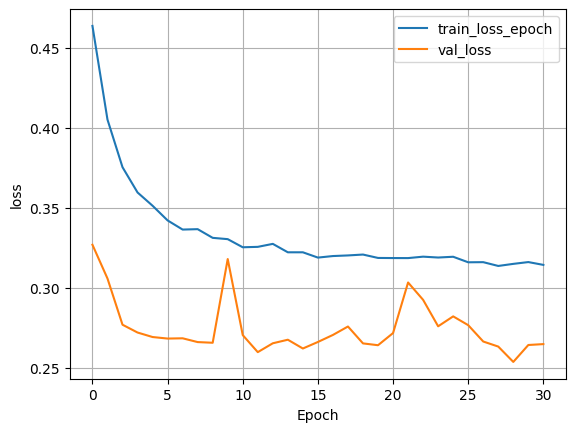

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.train_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)